In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
device = torch.device("mps")

In [3]:
#read the dataset
df = pd.read_csv('data/sample_2000.csv')
emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
neutral      452
happiness    452
surprise     368
sadness      268
anger        252
disgust      208
Name: count, dtype: int64


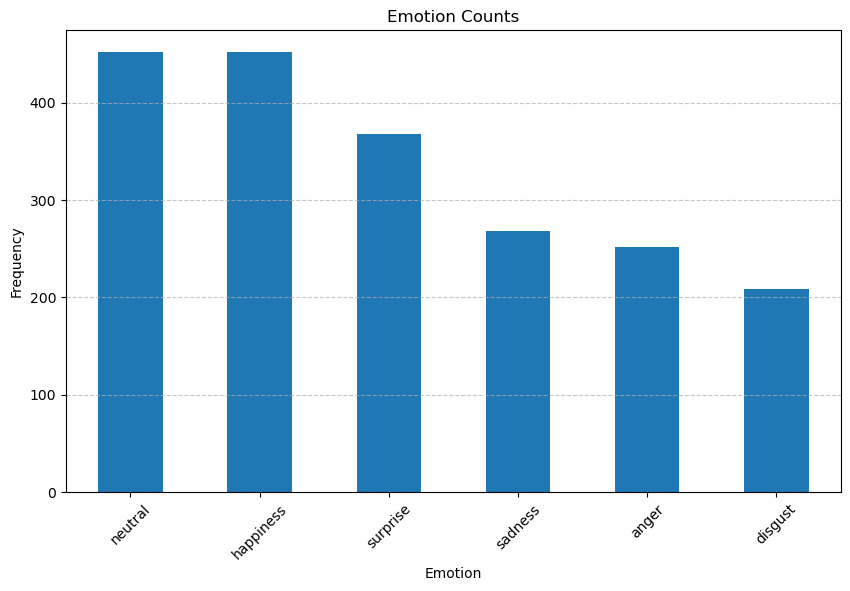

In [4]:
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Transform the labels into integer

In [5]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
print(label_encoder.classes_)
print(df)

['anger' 'disgust' 'happiness' 'neutral' 'sadness' 'surprise']
     user.id                            image    emotion  emotion_encoded
0        628  facial-expressions_2868588k.jpg      anger                0
1        628  facial-expressions_2868585k.jpg   surprise                5
2        628  facial-expressions_2868584k.jpg    disgust                1
3        302        Abdullah_Nasseef_0001.jpg   surprise                5
4        302               Adam_Mair_0001.jpg   surprise                5
...      ...                              ...        ...              ...
1995     302           Harrison_Ford_0008.jpg  happiness                2
1996   dwdii              Tony_Blair_0102.jpg  happiness                2
1997   dwdii           Jessica_Lynch_0002.jpg  happiness                2
1998   dwdii              Tim_Henman_0016.jpg  happiness                2
1999   dwdii             Mike_Easley_0001.jpg  happiness                2

[2000 rows x 4 columns]


# Prepare dataset

In [6]:
# check the dimension of the original dataset
image_path = "images/Aaron_Eckhart_0001.jpg"
image = cv2.imread(image_path)
height, width, channels = image.shape
print(f"Resolution for each image: {width}x{height}, Channels: {channels}")

Resolution for each image: 350x350, Channels: 3


In [7]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, images_folder):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with image filenames and encoded labels.
            images_folder (str): Path to the folder containing the images.
        """
        self.dataframe = dataframe
        self.images_folder = images_folder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_filename = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['emotion_encoded']

        image_path = os.path.join(self.images_folder, image_filename)
        image = cv2.imread(image_path)

        # Resize and normalize the image
        image_resized = cv2.resize(image, (224, 224))
        image_normalized = image_resized / 255.0

        # Flatten the image into a vector
        image_vector = image_normalized.flatten()

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        # Convert image to a tensor
        image_tensor = torch.tensor(image_vector, dtype=torch.float32)

        return image_tensor, label

In [8]:
# Turn the dataset into the pytorch's dataloader
dataset = EmotionDataset(dataframe=df, images_folder="images")

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)

In [9]:
# test for the first batch
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Images Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")
    break

Batch 0:
Images Shape: torch.Size([32, 150528])
Labels Shape: torch.Size([32])


# Define Neural Net Class

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size*4)
        self.fc2 = nn.Linear(in_features=hidden_size*4, out_features=hidden_size*2)
        self.fc3 = nn.Linear(in_features=hidden_size*2, out_features=num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
num_epochs = 15
num_classes = 6
hidden_size = 512

criterion = nn.CrossEntropyLoss()
model = NeuralNet(input_size=150528, hidden_size=hidden_size, num_classes=num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model

In [12]:
def train(train_loader, test_loader, model, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
    
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_train_loss += loss.item()
    
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
    
        # Validation loop
        model.eval()
        running_val_loss = 0.0
    
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
    
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                running_val_loss += loss.item()
    
        # Record validation loss
        epoch_val_loss = running_val_loss / len(test_loader)
        val_losses.append(epoch_val_loss)
    
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        
    return train_losses, val_losses

In [13]:
train_losses, val_losses = train(train_loader, test_loader, model, optimizer, criterion)

Epoch [1/15] - Train Loss: 2.2855, Val Loss: 1.8431
Epoch [2/15] - Train Loss: 1.5884, Val Loss: 1.4570
Epoch [3/15] - Train Loss: 1.5279, Val Loss: 1.5423
Epoch [4/15] - Train Loss: 1.4106, Val Loss: 1.4986
Epoch [5/15] - Train Loss: 1.3204, Val Loss: 1.4908
Epoch [6/15] - Train Loss: 1.2842, Val Loss: 1.6875
Epoch [7/15] - Train Loss: 1.2894, Val Loss: 1.3523
Epoch [8/15] - Train Loss: 1.2310, Val Loss: 1.4582
Epoch [9/15] - Train Loss: 1.2422, Val Loss: 1.3487
Epoch [10/15] - Train Loss: 1.1682, Val Loss: 1.7256
Epoch [11/15] - Train Loss: 1.2569, Val Loss: 1.3513
Epoch [12/15] - Train Loss: 1.1606, Val Loss: 1.4780
Epoch [13/15] - Train Loss: 1.1440, Val Loss: 1.3034
Epoch [14/15] - Train Loss: 1.1326, Val Loss: 1.3758
Epoch [15/15] - Train Loss: 1.1277, Val Loss: 1.3144


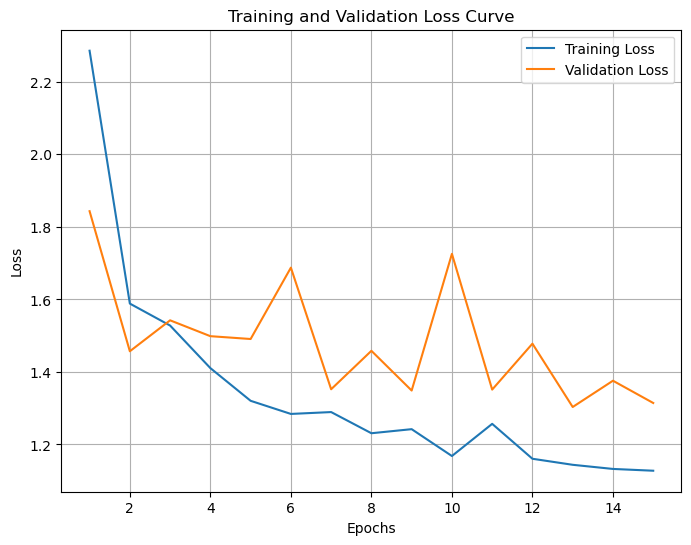

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [15]:
all_preds = []
all_labels = []

model.eval() 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

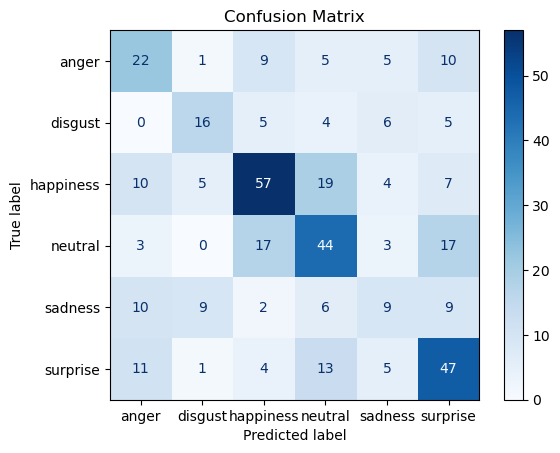

In [16]:
conf_matrix = confusion_matrix(all_labels, all_preds)

emotion_labels = label_encoder.classes_
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [17]:
report = classification_report(all_labels, all_preds, target_names=emotion_labels, output_dict=True, zero_division=0)
print(classification_report(all_labels, all_preds, target_names=emotion_labels, zero_division=0))

              precision    recall  f1-score   support

       anger       0.39      0.42      0.41        52
     disgust       0.50      0.44      0.47        36
   happiness       0.61      0.56      0.58       102
     neutral       0.48      0.52      0.50        84
     sadness       0.28      0.20      0.23        45
    surprise       0.49      0.58      0.53        81

    accuracy                           0.49       400
   macro avg       0.46      0.46      0.46       400
weighted avg       0.48      0.49      0.48       400



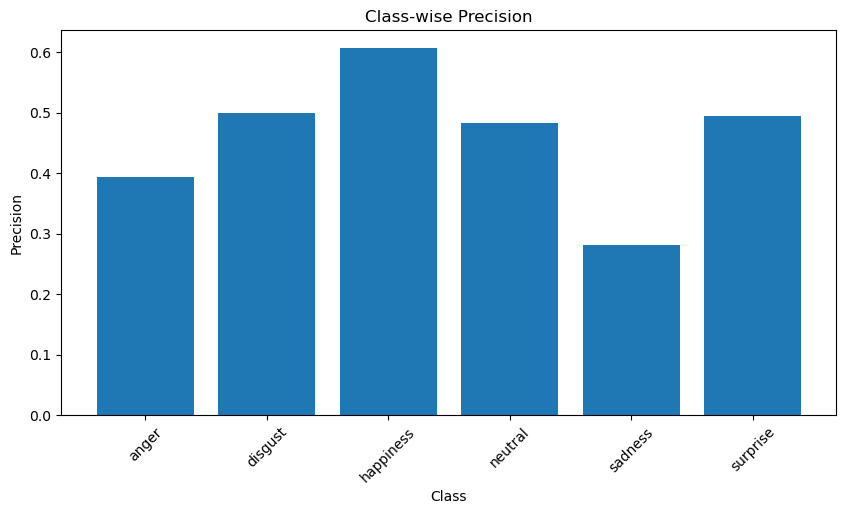

In [18]:
class_precisions = [report[label]['precision'] for label in emotion_labels if label in report]
class_recalls = [report[label]['recall'] for label in emotion_labels if label in report]
class_f1 = [report[label]['f1-score'] for label in emotion_labels if label in report]

plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, class_precisions)
plt.title('Class-wise Precision')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

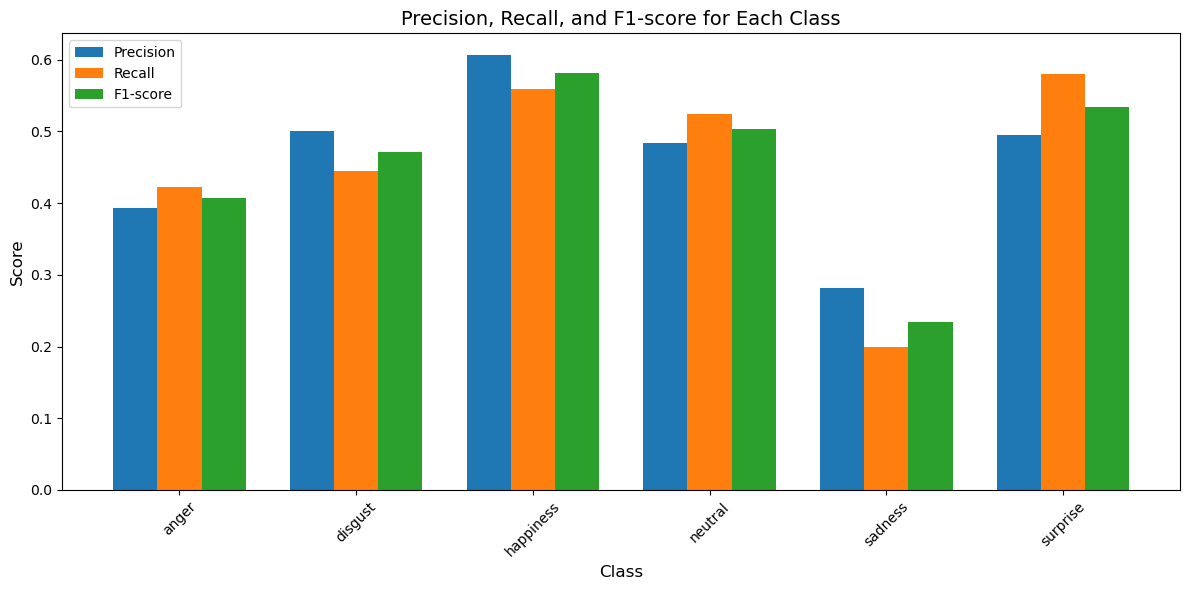

In [19]:
num_classes = len(emotion_labels)

bar_width = 0.25

x = np.arange(num_classes)

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, class_precisions, width=bar_width, label='Precision')
plt.bar(x, class_recalls, width=bar_width, label='Recall')
plt.bar(x + bar_width, class_f1, width=bar_width, label='F1-score')

plt.xlabel("Class", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision, Recall, and F1-score for Each Class", fontsize=14)
plt.xticks(x, emotion_labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()